# Goals
- Access and filter DESI EDR galaxy spectra data from a database using SPARCL.
- Process and normalize the spectra data to prepare it for model training.
- Develop a CNN autoencoder with skip connections to perform dimensionality reduction and reconstruction of the spectra.
- Train the autoencoder model using a weighted mean squared error (MSE) loss function to emphasize critical spectral features.
- Identify and visualize anomalies in the galaxy spectra based on high reconstruction errors.
- Provide visual representations of detected anomalies and evaluate the model's performance through training loss metrics.


# Summary
This project leverages the Dark Energy Spectroscopic Instrument (DESI) Early Data Release (EDR) dataset to train a Convolutional Neural Network (CNN) autoencoder for anomaly detection in galaxy spectra. The code retrieves galaxy spectra data from a database, processes and normalizes it, and then applies an autoencoder with skip connections to reconstruct the spectra. The reconstruction errors are used to identify anomalous spectra, which may indicate unusual features or observational issues in the data.

## Commands to run in terminal to upload changes to GitHub 
##### Note, to save and exit the commit comment section: Esc, ":wq", Enter


cd "/Users/elicox/Desktop/Mac/Work/Yr4 Work/Project/CNN-auto"

git add SpectralCNNAutoencoder.ipynb

output_dir="SpectralCNNAutoencoder_output"

latest_mean_reconstruction_error=$(ls -t SpectralCNNAutoencoder_output/mean_reconstruction_error_*.png | head -n 1)

latest_anomalous_spectra=$(ls -t SpectralCNNAutoencoder_output/anomalous_spectra_*.png | head -n 1)

latest_sampling_info=$(ls -t SpectralCNNAutoencoder_output/sampling_info_*.json | head -n 1)

if [ -f "$latest_mean_reconstruction_error" ]; then
    mv "$latest_mean_reconstruction_error" "$output_dir/"
    git add "$output_dir/$(basename "$latest_mean_reconstruction_error")"
fi

if [ -f "$latest_anomalous_spectra" ]; then
    mv "$latest_anomalous_spectra" "$output_dir/"
    git add "$output_dir/$(basename "$latest_anomalous_spectra")"
fi

if [ -f "$latest_sampling_info" ]; then
    mv "$latest_sampling_info" "$output_dir/"
    git add "$output_dir/$(basename "$latest_sampling_info")"
fi

git commit 

git push origin main


# Change log
<i> Place to log changes before they are recorded in a github update:

Added functionality to the plot_spectra function to plot specific galaxy spectra.

# Imports

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from tqdm import tqdm
from sparcl.client import SparclClient
from dl import queryClient as qc, authClient as ac
from getpass import getpass
import os
import re
import csv 
import torch.nn.functional as F
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import AutoMinorLocator
from torchviz import make_dot
import time
import random
from concurrent.futures import ThreadPoolExecutor, as_completed 
import logging
import json
import seaborn as sns
import requests
from io import BytesIO
from PIL import Image
import matplotlib.patches as patches

In [2]:
# Configure file directories
DATA_DIR = '/Users/elicox/Desktop/Mac/Work/Yr4 Work/Project/CNN-auto/'
OUT_DIR = os.path.join(DATA_DIR, 'SpectralCNNAutoencoder_output')
CSV_PATH = os.path.join(DATA_DIR, 'spectra_data.csv')
JSON_DIR = os.path.join(DATA_DIR, 'anomalous_regions')
os.makedirs(OUT_DIR, exist_ok=True)
#os.environ["PATH"] += os.pathsep + "/opt/homebrew/bin" # uncomment when CNN visualisation is needed

# Initialize SPARCL client
client = SparclClient()

# Data Loading and Saving Functions

In [3]:
def query_spectra_data():
    """
    Queries the DESI Early Data Release (EDR) database to retrieve galaxy spectra data, 
    filtering for primary spectra with a minimum number of coadded spectra and good quality flags.
    
    This function selects observational fields from the DESI EDR database:
        - `targetid`: Unique identifier for each galaxy.
        - `z`: Spectroscopic redshift.
        - `zwarn`: Redshift quality flag, where `zwarn = 0` indicates reliable data.
        - `coadd_fiberstatus`: Status of the fiber used for observation, with `0` indicating no issues.
        - `spectype`: Spectral type, filtered here to include only galaxies.
        - `mean_fiber_ra`, `mean_fiber_dec`: Mean Right Ascension and Declination of the fiber position.
        - `zcat_nspec`: Number of coadded spectra for the target.
        - `zcat_primary`: Indicates the primary spectrum for the target.
    Returns:
        pd.DataFrame: DataFrame with galaxy spectra data including flux error if available.
    """
    query = """
    SELECT zp.targetid, zp.z, zp.zwarn, zp.coadd_fiberstatus, zp.spectype, 
    zp.mean_fiber_ra, zp.mean_fiber_dec
    FROM desi_edr.zpix AS zp
    WHERE zp.zcat_primary = 't'
      AND zp.zcat_nspec > 2
      AND zp.spectype = 'GALAXY'
      AND zp.zwarn = '0'
    """
    try:
        zpix_cat = qc.query(sql=query, fmt='table')
        df = zpix_cat.to_pandas()
        print(f"Retrieved {len(df)} records from the database.")
        return df
    except Exception as e:
        print(f"Error querying data: {e}")
        return None


## Information about the query
- targetid, survey, program -- unique identifiers for a given spectrum
- healpix -- healpix number for the target
- z -- spectroscopic redshift of the target
- zwarn -- encoded information regarding the redshift (zwarn = 0 is good)
- coadd_fiberstatus -- encoded information regarding the fiber that is assigned to the target (coadd_fiberstatus = 0 is good)
- spectype -- Spectral type of the target: STAR | GALAXY | QSO
- mean_fiber_ra, mean_fiber_dec -- Mean R.A. and Dec. of the fiber position from all the observations of the target
- zcat_nspec -- Number of coadded spectra that are available for a given target
- zcat_primary -- Whether or not a given coadded spectrum is the primary spectrum. zcat_primary = True for the "best" spectrum.
- CASTing this column as an INT: zcat_primary = 1 for the "best" spectrum.
- desi_target -- encodes main survey's DESI targeting information - explained in detail below
- sv1_desi_target -- encodes sv1 desi targeting information
- sv2_desi_target -- encodes sv2 desi targeting information
- sv3_desi_target -- encodes sv3 desi targeting information

# Data Preparation Functions

In [4]:
def retrieve_flux(targetid, inc, retries=5, delay=2):
    """
    Retrieves and normalizes flux data, wavelength, and calculates error for a single target ID from the DESI database, with retry logic.
    
    Parameters:
    - targetid (int): The ID of the target for which flux data is requested.
    - inc (list of str): List of attributes to include in the data retrieval (e.g., ['specid', 'flux', 'wavelength', 'ivar']).
    - retries (int, optional): The number of retry attempts if data retrieval fails (default is 5).
    - delay (int, optional): The base delay in seconds between retries, with exponential backoff (default is 2).

    Returns:
    - tuple (np.array, np.array, np.array) or None: Normalized flux, wavelength, and error arrays if retrieval is successful; otherwise, None if all retries fail.
    """
    for attempt in range(1, retries + 1):
        try:
            # Attempt to retrieve the flux data
            res = client.retrieve_by_specid(specid_list=[targetid], include=inc, dataset_list=['DESI-EDR'])
            for record in res.records:
                if record['specprimary']:
                    flux = record['flux']
                    wavelength = record['wavelength']
                    ivar = record['ivar']  # Retrieve inverse variance for error calculation
                    
                    # Calculate normalized flux
                    flux_min, flux_max = np.min(flux), np.max(flux)
                    normalized_flux = (flux - flux_min) / (flux_max - flux_min)
                    
                    # Calculate error, setting zero ivar values to a small number to avoid division by zero
                    error = np.sqrt(1 / np.where(ivar == 0, 1e-10, ivar))

                    
                    return normalized_flux, wavelength, error  # Return flux, wavelength, and error arrays
        except Exception:
            if attempt < retries:
                time.sleep(delay * (2 ** (attempt - 1)))  # Exponential backoff
    return None  # Return None if all attempts fail



def process_spectra_data(zpix_cat, batch_size=20, max_workers=10):
    """
    Retrieves and processes flux data in parallel for a DataFrame of galaxy spectra from the DESI database,
    including flux, wavelength, and error data.

    Parameters:
    - zpix_cat (pd.DataFrame): DataFrame containing metadata for the galaxy spectra to be processed, including target IDs.
    - batch_size (int, optional): The number of spectra to retrieve in each batch (default is 20).
    - max_workers (int, optional): The maximum number of parallel threads for retrieving data (default is 10).

    Returns:
    - tuple (np.array, np.array, np.array): Arrays of normalized flux data, corresponding wavelength data, and error data for each galaxy spectrum.
    """
    all_fluxes = []
    all_wavelengths = []
    all_errors = []
    total_records = len(zpix_cat)
    inc = ['specid', 'redshift', 'flux', 'wavelength', 'ivar', 'spectype', 
           'specprimary', 'survey', 'program', 'targetid', 'coadd_fiberstatus']

    for start_idx in tqdm(range(0, total_records, batch_size), desc="Processing spectra in batches"):
        batch = zpix_cat.iloc[start_idx:start_idx+batch_size]
        batch_fluxes = []
        batch_wavelengths = []
        batch_errors = []

        # Parallelize requests within the batch
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            futures = {executor.submit(retrieve_flux, int(row['targetid']), inc): row['targetid'] for _, row in batch.iterrows()}
            for future in as_completed(futures):
                result = future.result()
                if result is not None:
                    flux, wavelength, error = result  # Unpack flux, wavelength, and error
                    batch_fluxes.append(flux)
                    batch_wavelengths.append(wavelength)
                    batch_errors.append(error)
                else:
                    print(f"Warning: Missing flux for target ID {futures[future]}") 

        all_fluxes.extend(batch_fluxes)
        all_wavelengths.extend(batch_wavelengths)
        all_errors.extend(batch_errors)

    if not all_fluxes:
        raise ValueError("Error: No flux data retrieved. Check data source or retrieval logic.")

    return np.array(all_fluxes), np.array(all_wavelengths), np.array(all_errors)
    
def pad_spectra(fluxes, target_length):
    """
    Pads or truncates each flux array in a collection to match a specified target length.
    
    Parameters:
    - fluxes (list of np.array): List of flux arrays for each spectrum.
    - target_length (int): Desired length for each flux array, used for padding or truncation.
    
    Returns:
    - np.array: Array of padded or truncated flux data.
    
    Notes:
    - Adds zeros to the end of shorter spectra to match the target length.
    - Truncates longer spectra to fit the specified target length.
    - Prints a count of spectra that required padding.
    """
    padded_fluxes = []
    num_padded = 0  # Track only the padded spectra

    for flux in fluxes:
        if len(flux) < target_length:
            padding = np.zeros(target_length - len(flux))
            padded_flux = np.concatenate([flux, padding])
            num_padded += 1
        else:
            padded_flux = flux[:target_length]
        padded_fluxes.append(padded_flux)

    if num_padded > 0:
        print(f"Padding applied to {num_padded} spectra to match the target length.")
    else:
        print("No padding was necessary; all spectra are of equal length.")

    return np.array(padded_fluxes)



def create_padding_mask(fluxes, target_length):
    """
    Generates a binary mask indicating the padded regions in each flux array.
    
    Parameters:
    - fluxes (list of np.array): List of flux arrays for each spectrum.
    - target_length (int): Length of the output mask arrays, matching the padded flux array length.
    
    Returns:
    - np.array: Array of binary masks for each flux array, where 1 represents original data and 0 represents padded values.
    
    Notes:
    - The mask is used during loss calculation to ignore the padded regions of the spectra.
    """
    masks = []
    for flux in fluxes:
        mask = np.ones_like(flux)
        if len(flux) < target_length:
            mask = np.concatenate([mask, np.zeros(target_length - len(flux))])
        masks.append(mask[:target_length])
    return np.array(masks)

In [22]:
# def filter_wavelength_range(wavelengths, fluxes, errors, min_wavelength=4000):
#     """
#     Filters out data points with wavelengths below a specified minimum.

#     Parameters:
#     - wavelengths (list of np.ndarray): Observed wavelengths for each spectrum.
#     - fluxes (list of np.ndarray): Flux values for each spectrum.
#     - errors (list of np.ndarray): Error values for each spectrum.
#     - min_wavelength (float): Minimum wavelength to retain.

#     Returns:
#     - filtered_wavelengths (list of np.ndarray): Filtered wavelengths.
#     - filtered_fluxes (list of np.ndarray): Filtered fluxes.
#     - filtered_errors (list of np.ndarray): Filtered errors.
#     """
#     filtered_wavelengths, filtered_fluxes, filtered_errors = [], [], []

#     for i in range(len(wavelengths)):
#         # Create a mask for wavelengths >= min_wavelength
#         mask = wavelengths[i] >= min_wavelength
        
#         # Apply the mask to each spectrum
#         filtered_wavelengths.append(wavelengths[i][mask])
#         filtered_fluxes.append(fluxes[i][mask])
#         filtered_errors.append(errors[i][mask])
#     for i, (wave, flux, error) in enumerate(zip(wavelengths, fluxes, errors)):
#         if len(wave) != len(flux) or len(wave) != len(error):
#             print(f"Mismatch detected at spectrum {i}:")
#             print(f"Wavelength length: {len(wave)}")
#             print(f"Flux length: {len(flux)}")
#             print(f"Error length: {len(error)}")
#     return filtered_wavelengths, filtered_fluxes, filtered_errors


# Autoencoder Model Definition

In [6]:
class CNNAutoencoderWithSkip(nn.Module):
    """
    A Convolutional Neural Network (CNN)-based autoencoder with skip connections for reconstructing spectral data.
    
    This model is designed to reduce the dimensionality of spectral data, capturing essential features 
    during encoding and reconstructing the data during decoding. Skip connections help retain 
    detailed information that may otherwise be lost in deeper layers, improving reconstruction 
    quality for tasks like anomaly detection or dimensionality reduction.
    
    Attributes:
    - encoder1 (nn.Conv1d): First convolutional layer of the encoder, reducing input dimensions.
    - encoder2 (nn.Conv1d): Second convolutional layer of the encoder, further reducing dimensions.
    - encoder3 (nn.Conv1d): Final convolutional layer of the encoder, creating a compressed representation.
    - decoder3 (nn.ConvTranspose1d): First transposed convolutional layer of the decoder.
    - decoder2 (nn.ConvTranspose1d): Second transposed convolutional layer of the decoder.
    - decoder1 (nn.ConvTranspose1d): Final transposed convolutional layer of the decoder, outputting the reconstructed data.
    
    Methods:
    - forward(x): Defines the forward pass of the autoencoder. The input data `x` passes through the encoder 
      layers to compress it, and then through the decoder layers to reconstruct it. Skip connections are 
      used to combine encoder and decoder layers at corresponding depths.
      
    Returns:
    - torch.Tensor: The reconstructed tensor, with values squashed between 0 and 1 using a sigmoid activation.
    """
    def __init__(self):
        super(CNNAutoencoderWithSkip, self).__init__()
        # Encoder layers with reduced channels
        self.encoder1 = nn.Conv1d(1, 64, kernel_size=3, stride=2, padding=1)
        self.encoder2 = nn.Conv1d(64, 32, kernel_size=3, stride=2, padding=1)
        self.encoder3 = nn.Conv1d(32, 16, kernel_size=3, stride=2, padding=1)  

        # Decoder layers with reduced channels
        self.decoder3 = nn.ConvTranspose1d(16, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.decoder2 = nn.ConvTranspose1d(32, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.decoder1 = nn.ConvTranspose1d(64, 1, kernel_size=3, stride=2, padding=1, output_padding=0)

    def forward(self, x):
        # Encoding with skip connections
        x1 = F.relu(self.encoder1(x))  # Save this for skip connection
        x2 = F.relu(self.encoder2(x1))  # Save this for skip connection
        x3 = F.relu(self.encoder3(x2))  # Last encoding layer

        # Decoding with skip connections
        x = F.relu(self.decoder3(x3))
        
        # Adjust sizes for skip connection with x2
        if x2.size(2) > x.size(2):
            x2 = x2[:, :, :x.size(2)]
        elif x2.size(2) < x.size(2):
            x = x[:, :, :x2.size(2)]
        x = F.relu(self.decoder2(x + x2))
        
        # Adjust sizes for skip connection with x1
        if x1.size(2) > x.size(2):
            x1 = x1[:, :, :x.size(2)]
        elif x1.size(2) < x.size(2):
            x = x[:, :, :x1.size(2)]
        x = self.decoder1(x + x1)

        return torch.sigmoid(x)

# Custom Loss Function


In [7]:
def weighted_mse_loss(observed_flux, target_flux, mask, error_on_observed_flux):
    """
    Calculates a modified Mean Squared Error (MSE) loss based on the "significance difference"
    between observed and target flux, adjusted by the observational error.

    Parameters:
    - observed_flux (torch.Tensor): The model's predicted flux values (reconstructed spectra).
    - target_flux (torch.Tensor): The ground truth flux values to be compared against observed_flux.
    - mask (torch.Tensor): A binary mask that identifies which regions in the spectra should be included
                           in the loss calculation, typically to ignore padded regions.
    - error_on_observed_flux (torch.Tensor): Observational error associated with each flux point.

    Returns:
    - torch.Tensor: The mean significance-based MSE loss, adjusted by the mask to ignore specific regions.

    Process:
    1. Compute the "significance difference" by normalizing the difference between observed and target flux
       using `error_on_observed_flux`, which represents the observational uncertainty.
    2. Square the resulting "significance difference" to get a MSE-like loss, which is focused on relative
       significance rather than absolute difference.
    3. Apply the mask to this significance-based MSE loss to focus only on relevant parts of the spectrum.
    4. Return the mean of the masked, significance-based MSE loss.
    """
    # Ensure error_on_observed_flux is non-zero to avoid division issues
    significance_difference = (observed_flux - target_flux) / (error_on_observed_flux + 1e-5)
    mse_loss = significance_difference ** 2
    
    # Apply the mask to ignore padded regions
    return (mse_loss * mask).mean()


# Training the Model


In [8]:
def train_autoencoder(model, data, mask, errors, epochs=50, batch_size=32, lr=0.001, grad_clip=1.0):
    """
    Trains an autoencoder model using mini-batch gradient descent with gradient clipping 
    and a custom weighted MSE loss function that incorporates errors.
    
    Parameters:
    - model (torch.nn.Module): The autoencoder model to be trained.
    - data (torch.Tensor): Input data tensor (spectra).
    - mask (torch.Tensor): Padding mask tensor.
    - errors (torch.Tensor): Errors associated with the data.
    - epochs, batch_size, lr, grad_clip: Training parameters.
    
    Process:
    1. Initializes the optimizer and trains the model over epochs.
    2. Passes errors to the loss function for significance-based weighting.
    """
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()

    for epoch in range(epochs):
        start_time = time.time()
        epoch_loss = 0
        optimizer.zero_grad()  # Zero gradients at the start of each epoch

        for i in range(0, len(data), batch_size):
            batch_data, mask_batch, error_batch = data[i:i+batch_size], mask[i:i+batch_size], errors[i:i+batch_size]
            loss = weighted_mse_loss(model(batch_data), batch_data, mask_batch, error_batch)
            loss.backward()

            # Clip gradients to prevent explosions
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()
            optimizer.zero_grad()  # Zero gradients after each batch

            epoch_loss += loss.item()

        epoch_duration = time.time() - start_time
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(data):.8f}, Time: {epoch_duration:.2f}s")
    print(f"Final Loss after {epochs} epochs: {epoch_loss/len(data):.8f}")


# Anomaly Detection

In [9]:
def detect_anomalous_regions(original_fluxes, reconstructed_fluxes, window_size=50, percentile_threshold=95, 
                             range_mismatch_factor=1.5, overall_anomaly_threshold=0.3):
    """
    Identifies anomalous regions within spectra using residuals and mismatch factors,
    with added logging to justify each detected anomaly and the triggering value.

    Parameters:
    ----------
    original_fluxes : np.ndarray
        A 2D array of original flux values from the spectra, with shape (num_spectra, spectrum_length).
        Each row represents a spectrum, and each column corresponds to a specific wavelength or flux point.

    reconstructed_fluxes : np.ndarray
        A 2D array of reconstructed flux values from the model, with the same shape as `original_fluxes`.
        These are the model’s best attempt to recreate the original spectra, used to compute errors.

    window_size : int, optional, default=50
        The size of the sliding window (in data points) used to analyze local regions within each spectrum.
        Smaller windows focus on more localized anomalies, while larger windows capture broader trends.

    percentile_threshold : float, optional, default=95
        The percentile used to set the anomaly detection thresholds for both absolute and relative residuals.
        For example, a value of 95 means that only regions with errors in the top 5% are considered for anomalies.

    range_mismatch_factor : float, optional, default=1.5
        A factor to identify anomalies based on the range mismatch between original and reconstructed fluxes.
        If the range of reconstructed values exceeds this factor times the original range, the region is flagged as anomalous.

    overall_anomaly_threshold : float, optional, default=0.3
        The minimum fraction of a spectrum that must be flagged as anomalous to classify the entire spectrum as anomalous.
        For example, a value of 0.3 means that at least 30% of the spectrum must be flagged for the spectrum to be considered anomalous.

    Returns:
    -------
    anomalies : list of np.ndarray
        A list of boolean arrays, each representing a spectrum. Each array has True at positions corresponding to
        flagged regions in the spectrum and False otherwise.

    spectrum_anomalies : np.ndarray
        A 1D boolean array where each element represents whether the corresponding spectrum is classified as anomalous.

    anomaly_metadata : list of list of dict
        Metadata for each flagged region in each spectrum, with information on the range of the anomaly,
        the type of anomaly (high absolute residual, high relative residual, or range mismatch), and the value that triggered the flag.

    abs_residual_threshold : float
        The threshold value for absolute residuals beyond which regions are flagged as anomalous.

    rel_residual_threshold : float
        The threshold value for relative residuals beyond which regions are flagged as anomalous.

    range_mismatch_factor : float
        The factor used to determine if the reconstructed flux range mismatch flags a region as anomalous.
    """

    num_spectra, spectrum_length = original_fluxes.shape
    absolute_residuals = np.abs(original_fluxes - reconstructed_fluxes)
    relative_residuals = np.abs((original_fluxes - reconstructed_fluxes) / (original_fluxes + 1e-5))

    # Calculate thresholds for anomaly detection
    abs_residual_threshold = float(np.percentile(
        [np.mean(absolute_residuals[:, i:i+window_size], axis=1)
         for i in range(0, spectrum_length - window_size + 1, window_size // 2)], percentile_threshold))
    rel_residual_threshold = float(np.percentile(
        [np.mean(relative_residuals[:, i:i+window_size], axis=1)
         for i in range(0, spectrum_length - window_size + 1, window_size // 2)], percentile_threshold))

    anomalies, spectrum_anomalies = [], np.zeros(num_spectra, dtype=bool)
    anomaly_metadata = []

    for i in range(num_spectra):
        spectrum_anomalies_count = 0
        spectrum_anomaly_flags = np.zeros(spectrum_length, dtype=bool)
        anomaly_justification = []

        for start in range(0, spectrum_length - window_size + 1, window_size // 2):
            end = start + window_size
            window_abs_residual = float(np.mean(absolute_residuals[i, start:end]))
            window_rel_residual = float(np.mean(relative_residuals[i, start:end]))
            original_range = float(np.ptp(original_fluxes[i, start:end]))
            reconstructed_range = float(np.ptp(reconstructed_fluxes[i, start:end]))

            if (window_abs_residual > abs_residual_threshold or
                window_rel_residual > rel_residual_threshold or
                reconstructed_range > original_range * range_mismatch_factor):
                
                spectrum_anomaly_flags[start:end] = True
                spectrum_anomalies_count += end - start

                # Justification metadata with trigger values
                reason = {
                    "range_start": start,
                    "range_end": end,
                    "reason_type": (
                        "high_absolute_residual" if window_abs_residual > abs_residual_threshold else
                        "high_relative_residual" if window_rel_residual > rel_residual_threshold else
                        "range_mismatch"
                    ),
                    "trigger_value": (
                        window_abs_residual if window_abs_residual > abs_residual_threshold else
                        window_rel_residual if window_rel_residual > rel_residual_threshold else
                        reconstructed_range / (original_range + 1e-5)
                    )
                }
                anomaly_justification.append(reason)

        spectrum_anomalies[i] = spectrum_anomalies_count / spectrum_length > overall_anomaly_threshold 
        anomalies.append(spectrum_anomaly_flags)
        anomaly_metadata.append(anomaly_justification)

    # Return anomalies, metadata, and threshold values
    return anomalies, spectrum_anomalies, anomaly_metadata, abs_residual_threshold, rel_residual_threshold, range_mismatch_factor

# Spectra Visualisation

In [10]:
def create_save_path(save_directory, base_filename):
    """
    Generates a unique file path for PNG files in the specified directory by appending
    a sequential numeric suffix to avoid overwriting existing files. This ensures that
    saved file names are uniquely numbered.

    Parameters:
    - save_directory (str): The directory where the file should be saved. It will be created if it doesn't exist.
    - base_filename (str): The base name for the file, to which a numeric suffix will be added.

    Returns:
    - str: A full path to the new file with a sequentially numbered suffix in the specified directory,
           following the format '{base_filename}_{number}.png'.
    """

    os.makedirs(save_directory, exist_ok=True)
    existing_files = os.listdir(save_directory)
    numbers = [
        int(re.search(r'\d+', f).group())
        for f in existing_files if re.search(fr'{base_filename}_(\d+)\.png', f)
    ]
    next_number = max(numbers) + 1 if numbers else 1
    full_path = os.path.join(save_directory, f'{base_filename}_{next_number}.png')
    
    relative_path = os.path.relpath(full_path, start=os.path.dirname(save_directory))
    
    return relative_path
    
def create_json_save_path(save_directory, base_filename):
    """
    Generates a unique file path for JSON files in the specified directory by appending
    a sequential numeric suffix to avoid overwriting existing files. This ensures that
    saved JSON file names are uniquely numbered.

    Parameters:
    - save_directory (str): The directory where the JSON file should be saved. It will be created if it doesn't exist.
    - base_filename (str): The base name for the JSON file, to which a numeric suffix will be added.

    Returns:
    - str: A full path to the new JSON file with a sequentially numbered suffix in the specified directory,
           following the format '{base_filename}_{number}.json'.
    """
    os.makedirs(save_directory, exist_ok=True)
    existing_files = os.listdir(save_directory)
    numbers = [
        int(re.search(rf'{base_filename}_(\d+)\.json', f).group(1))
        for f in existing_files if re.search(rf'{base_filename}_(\d+)\.json', f)
    ]
    next_number = max(numbers) + 1 if numbers else 1
    full_path = os.path.join(save_directory, f'{base_filename}_{next_number}.json')
    relative_path = os.path.relpath(full_path, start=os.path.dirname(save_directory))
    
    return relative_path

In [11]:
def save_sampling_info(galaxy_ids, plot_galaxy_ids, seed, anomaly_metadata, abs_residual_threshold, 
                       rel_residual_threshold, range_mismatch_factor, json_directory, zpix_cat):
    """
    Saves detailed sampling information for detected anomalous spectra to a JSON file. This includes 
    metadata on each detected anomaly, threshold values, and unique target IDs associated with the anomalies.

    Parameters:
    - galaxy_ids (list of int): Indices of galaxies identified as anomalous, corresponding to row indices in `zpix_cat`.
    - plot_galaxy_ids (list of int): Indices of galaxies selected for plotting, used to match target IDs if needed.
    - seed (int): Random seed used during sampling to ensure reproducibility.
    - anomaly_metadata (list of list of dict): Metadata for each galaxy's anomaly detection results, where each inner list
      contains dictionaries with specific anomaly information (e.g., range, justification, trigger value).
    - abs_residual_threshold (float): Threshold for detecting high absolute residual anomalies.
    - rel_residual_threshold (float): Threshold for detecting high relative residual anomalies.
    - range_mismatch_factor (float): Factor threshold for range mismatches between original and reconstructed spectra.
    - json_directory (str): Directory path where the JSON file should be saved. Will be created if it doesn't exist.
    - zpix_cat (DataFrame): DataFrame containing galaxy catalog information, including `targetid` for each galaxy.

    Returns:
    - None: The function saves a JSON file containing the sampling and anomaly data.

    Process:
    1. Maps `galaxy_ids` to actual `targetid` values using `zpix_cat` to provide unique identifiers for each galaxy.
    2. Constructs a dictionary `sampling_info` to store:
       - Count of anomalies detected.
       - Sampling seed for reproducibility.
       - Thresholds for absolute residual, relative residual, and range mismatch.
       - An `anomalous_spectra` dictionary keyed by `targetid`, where each entry holds `anomaly_ranges` metadata.
    3. For each `targetid`, populates `anomaly_ranges` with details on each anomaly's range, justification, 
       and the value triggering the anomaly.
    4. Uses `create_json_save_path` to generate a unique, sequentially numbered file path for saving.
    5. Writes `sampling_info` as JSON to the generated path and confirms save location with a printed message.
    """
    # Convert galaxy indices to target IDs using zpix_cat
    target_ids = [int(zpix_cat['targetid'].iloc[idx]) for idx in galaxy_ids]

    sampling_info = {
        "Number of Anomalies": len(target_ids),
        "Seed": int(seed),
        "absolute_residual_threshold": float(abs_residual_threshold),
        "relative_residual_threshold": float(rel_residual_threshold),
        "range_mismatch_factor": float(range_mismatch_factor),
        "anomalous_spectra": {}
    }

    for idx, target_id in enumerate(target_ids):
        metadata = anomaly_metadata[idx]
        anomaly_ranges = []

        for reason in metadata:
            anomaly_ranges.append({
                "range_start": reason["range_start"],
                "range_end": reason["range_end"],
                "justification": reason["reason_type"],
                "value": reason.get("trigger_value", None)  # Include actual triggering value
            })

        sampling_info["anomalous_spectra"][target_id] = {
            "anomaly_ranges": anomaly_ranges
        }

    # Generate a JSON save path with a unique name
    json_path = create_json_save_path(json_directory, 'sampling_info')
    secondary_path = create_json_save_path(OUT_DIR, 'sampling_info')

    # Write the JSON data to the file
    with open(json_path, 'w') as json_file:
        json.dump(sampling_info, json_file, indent=4)
    with open(secondary_path, 'w') as json_file:
        json.dump(sampling_info, json_file, indent=4)
    
    print(f"Sampling information saved to {json_path} and {secondary_path}")

In [12]:
def fetch_sdss_image(ra, dec, scale=0.2, width=256, height=256, data_release="DR17"):
    """
    Fetches an SDSS image for the specified coordinates.

    Parameters:
    - ra (float): Right Ascension (RA) in degrees for the target.
    - dec (float): Declination (DEC) in degrees for the target.
    - scale (float): Scaling factor for the image, affecting zoom level. Default is 0.2.
    - width (int): Width of the returned image in pixels. Default is 256.
    - height (int): Height of the returned image in pixels. Default is 256.
    - data_release (str): SDSS data release version to retrieve the image from, e.g., "DR17".

    Returns:
    - BytesIO: A byte stream containing the image if the retrieval is successful.
    - None: Returns None if the image retrieval fails.
    """
    url = f"http://skyserver.sdss.org/{data_release}/SkyServerWS/ImgCutout/getjpeg?ra={ra}&dec={dec}&scale={scale}&width={width}&height={height}"
    response = requests.get(url)
    if response.status_code == 200:
        return BytesIO(response.content)
    return None


def plot_spectra(
    original_fluxes, reconstructed_fluxes, anomalous_regions, spectrum_anomalies,
    zpix_cat, wavelengths=None, save_directory='SpectralCNNAutoencoder_output', max_samples=20, 
    seed=None, only_anomalous=True, specific_ids=None, specific_coords=None, coord_tolerance=0.01
):
    """
    Plots original and reconstructed spectra for multiple galaxies, with options to highlight anomalies
    and plot only specified galaxies based on IDs or coordinates.

    Parameters:
    - original_fluxes (list of ndarray): Original flux values for each spectrum.
    - reconstructed_fluxes (list of ndarray): Reconstructed flux values, for comparison.
    - anomalous_regions (list of lists of bool): Each list indicates anomalous regions in a spectrum.
    - spectrum_anomalies (list of bool): Flags if a given spectrum is anomalous. 
    - zpix_cat (DataFrame): Metadata with RA/Dec information and galaxy IDs.
    - wavelengths (ndarray, optional): Wavelengths for x-axis; defaults to index if None.
    - save_directory (str, optional): Directory to save the generated plot.
    - max_samples (int, optional): Max number of spectra to plot.
    - seed (int, optional): Seed for random sampling.
    - only_anomalous (bool, optional): If True, only plots spectra marked as anomalous.
    - specific_ids (list of int, optional): List of galaxy IDs to plot, if specified.
    - specific_coords (list of tuple, optional): List of (RA, DEC) tuples to plot spectra for specific coordinates.
    - coord_tolerance (float, optional): Tolerance for matching coordinates in degrees.

    Returns:
    - tuple: (anomalous_indices, plot_indices, seed) for the plotted spectra.
    """
    # Filter by specific galaxy IDs if provided
    if specific_ids is not None:
        filtered_indices = zpix_cat[zpix_cat['targetid'].isin(specific_ids)].index.tolist()
    # Filter by coordinates if provided
    elif specific_coords is not None:
        filtered_indices = []
        for ra, dec in specific_coords:
            matches = zpix_cat[(abs(zpix_cat['mean_fiber_ra'] - ra) < coord_tolerance) &
                               (abs(zpix_cat['mean_fiber_dec'] - dec) < coord_tolerance)]
            filtered_indices.extend(matches.index.tolist())
    else:
        filtered_indices = list(range(len(original_fluxes)))

    # Limit to anomalous spectra if required
    if only_anomalous:
        filtered_indices = [i for i in filtered_indices if spectrum_anomalies[i]]
    
    # Sampling setup for reproducibility
    if seed is None:
        seed = random.randint(0, 10000)
    random.seed(seed)

    # Select spectra to plot based on max_samples
    plot_indices = random.sample(filtered_indices, min(max_samples, len(filtered_indices)))
    
    # Plotting logic remains mostly unchanged
    fig, axes = plt.subplots(len(plot_indices), 2, figsize=(15, 6 * len(plot_indices)), gridspec_kw={'width_ratios': [3, 1]})
    if len(plot_indices) == 1:
        axes = [axes]  # Ensure axes is iterable for a single plot

    for idx, i in enumerate(plot_indices):
        ra, dec = zpix_cat.loc[i, ['mean_fiber_ra', 'mean_fiber_dec']]
        x_axis = wavelengths if wavelengths is not None else range(len(original_fluxes[i]))

        # Column 1: Plot spectra
        ax_spectra = axes[idx, 0]
        ax_spectra.plot(x_axis, original_fluxes[i], label="Original", color='#2c7bb6', linewidth=0.5)
        ax_spectra.plot(x_axis, reconstructed_fluxes[i], label="Reconstructed", color='#d7191c', alpha=0.7, linewidth=0.5)

        # Highlight anomalous regions
        in_anomaly, anomaly_start = False, 0
        for j in range(len(x_axis)):
            if anomalous_regions[i][j] and not in_anomaly:
                anomaly_start = j
                in_anomaly = True
            elif not anomalous_regions[i][j] and in_anomaly:
                ax_spectra.axvspan(x_axis[anomaly_start], x_axis[j], color='#fdae61', alpha=0.7)
                in_anomaly = False
        if in_anomaly:
            ax_spectra.axvspan(x_axis[anomaly_start], x_axis[-1], color='#fdae61', alpha=0.7)
         # Set background for anomalous spectra
        if spectrum_anomalies[i]:
            ax_spectra.set_facecolor('#fee090')
            ax_spectra.set_title(f"Spectrum ID: {zpix_cat['targetid'].iloc[i]} - Anomalous", color='red')
        else:
            ax_spectra.set_title(f"Spectrum ID: {zpix_cat['targetid'].iloc[i]}", color='black')
        # Add residuals plot
        divider = make_axes_locatable(ax_spectra)
        ax_residual = divider.append_axes("bottom", size="25%", pad=0, sharex=ax_spectra)
        ax_residual.plot(x_axis, original_fluxes[i] - reconstructed_fluxes[i], color='#4dac26', linewidth=0.5)
        ax_residual.set_ylabel("Residuals")
        ax_spectra.set_ylabel("Flux (normalized)")
        ax_spectra.set_xlabel("Wavelength (Å)")
        ax_spectra.legend()

        # Column 2: Display SDSS image
        img_data = fetch_sdss_image(ra, dec)
        ax_image = axes[idx, 1]
        if img_data:
            img = Image.open(img_data)
            ax_image.imshow(img)
            ax_image.set_title(f"Galaxy Image\nRA={ra:.4f}, Dec={dec:.4f}")
            circle_radius = 30
            circle = patches.Circle((128, 128), circle_radius, transform=ax_image.transData, edgecolor="white", facecolor="none", linewidth=2)
            ax_image.add_patch(circle)
        else:
            ax_image.text(0.5, 0.5, "Image Not Found", ha="center", va="center")
        ax_image.axis("off")

    plt.tight_layout()
    save_path = create_save_path(save_directory, 'selected_spectra')
    plt.savefig(save_path, dpi=300)
    plt.close()
    print(f"Figure saved to {save_path}")
    return filtered_indices, plot_indices, seed


In [13]:
def visualize_autoencoder(autoencoder, input_data):
    """
    Visualizes the entire structure of the autoencoder model by generating a graph of the
    network's architecture, including both encoder and decoder layers, and saves it as an image.

    Parameters:
    - autoencoder (nn.Module): The autoencoder model instance to visualize.
    - input_data (torch.Tensor): A sample input tensor for passing through the model to generate 
                                 the visualization. This input should match the model's expected input shape.
    Returns:
    - None. The function saves the visualization image file to `OUT_DIR` and outputs the path.
    """
    outputs = autoencoder(input_data)
    model_viz = make_dot(outputs, params=dict(autoencoder.named_parameters()))
    model_viz.format = "png"
    save_path = create_save_path(OUT_DIR, 'autoencoder_visualization')
    model_viz.render(save_path.replace(".png", ""))
    print(f"Full autoencoder visualization saved to {save_path}")

def visualize_encoder(autoencoder, input_data):
    """
    Visualizes the encoder section of the autoencoder model, which compresses input data into a 
    lower-dimensional representation. Saves the encoder visualization as an image.

    Parameters:
    - autoencoder (nn.Module): The autoencoder model instance containing the encoder layers.
    - input_data (torch.Tensor): A sample input tensor for passing through only the encoder 
                                 layers. The input shape should match the encoder's expected input.

    Returns:
    - None. The function saves the encoder visualization image to `OUT_DIR` and outputs the path.
    """
    encoder_output = autoencoder.encoder3(autoencoder.encoder2(autoencoder.encoder1(input_data)))
    encoder_viz = make_dot(encoder_output, params=dict(autoencoder.named_parameters()), 
                           show_attrs=True, show_saved=True)
    encoder_viz.format = "png"
    save_path = create_save_path(OUT_DIR, 'encoder_visualization')
    encoder_viz.render(save_path.replace(".png", ""))
    print(f"Encoder visualization saved to {save_path}")


def visualize_decoder(autoencoder, encoded_input):
    """
    Visualizes the decoder portion of the autoencoder model, which reconstructs the original 
    data from a lower-dimensional encoding. Saves the decoder visualization as an image.

    Parameters:
    - autoencoder (nn.Module): The autoencoder model instance containing the decoder layers.
    - encoded_input (torch.Tensor): An encoded representation that serves as the input to the 
                                    decoder layers. This should match the expected shape of the 
                                    decoder's input.
    Returns:
    - None. The function saves the decoder visualization image to `OUT_DIR` and outputs the path.
    """
    decoder_output = autoencoder.decoder1(autoencoder.decoder2(autoencoder.decoder3(encoded_input)))
    decoder_viz = make_dot(decoder_output, params=dict(autoencoder.named_parameters()), 
                           show_attrs=True, show_saved=True)
    decoder_viz.format = "png"
    save_path = create_save_path(OUT_DIR, 'decoder_visualization')
    decoder_viz.render(save_path.replace(".png", ""))
    print(f"Decoder visualization saved to {save_path}")

In [24]:
def compute_reconstruction_errors(original_fluxes, reconstructed_fluxes, method="mse"):
    """
    Computes reconstruction errors between original and reconstructed fluxes.

    Parameters:
    - original_fluxes (np.ndarray): Original flux values.
    - reconstructed_fluxes (np.ndarray): Reconstructed flux values from the model.
    - method (str): Error computation method, either 'mse' for mean squared error or 'mae' for mean absolute error.

    Returns:
    - np.ndarray: Array of errors with shape (num_spectra, num_wavelengths).
    """
    if method == "mse":
        errors = (original_fluxes - reconstructed_fluxes) ** 2
    elif method == "mae":
        errors = np.abs(original_fluxes - reconstructed_fluxes)
    else:
        raise ValueError("Method must be 'mse' or 'mae'")
    
    return errors

# def plot_reconstruction_error_distribution(reconstruction_errors, wavelengths=None, save_directory='output_images'):
#     """
#     Visualizes the reconstruction error distribution across wavelengths.

#     Parameters:
#     - reconstruction_errors (np.ndarray): Array of reconstruction errors per spectrum and wavelength.
#     - wavelengths (array-like, optional): Array of wavelength values corresponding to each error point.
#                                           If None, uses indices as the x-axis.
#     - save_directory (str, optional): Directory path to save the generated plot image.
#     """
#     # Calculate mean error at each wavelength across all spectra
#     mean_errors = np.mean(reconstruction_errors, axis=0)  # Mean across spectra for each wavelength

#     # Ensure x-axis is defined correctly
#     x_axis = wavelengths if wavelengths is not None else np.arange(mean_errors.shape[0])
#     # x_axis = np.arange(mean_errors.shape[0])  # Adjust to match 1D array

#     # Plot mean reconstruction error across wavelengths
#     plt.figure(figsize=(12, 6))
#     plt.plot(x_axis, mean_errors, label='Mean Reconstruction Error', color='blue', linewidth=0.5)
#     plt.fill_between(x_axis, mean_errors, color='blue', alpha=0.3)
#     plt.xlabel("Wavelength (Å)")
#     plt.ylabel("Mean Reconstruction Error")
#     plt.title("Reconstruction Error Distribution Across Wavelengths")
#     plt.legend()

#     # Save the plot
#     os.makedirs(save_directory, exist_ok=True)
#     line_plot_path = create_save_path(save_directory, 'mean_reconstruction_error')
#     plt.savefig(line_plot_path, dpi=300)
#     print(f"Plot of mean reconstruction error saved to {line_plot_path}")
def plot_reconstruction_error(reconstruction_errors, wavelengths=None, save_directory='output_images'):
    """
    Visualizes the reconstruction error distribution across wavelengths.
    """
    # Ensure reconstruction_errors is 2D
    assert len(reconstruction_errors.shape) == 2, "Expected reconstruction_errors to be 2D"
    
    # Calculate mean error at each wavelength
    mean_errors = np.mean(reconstruction_errors, axis=0)  # 1D array
    
    # Check if wavelengths are provided and align with mean_errors
    if wavelengths is not None:
        if isinstance(wavelengths, list) and len(wavelengths) > 1 and isinstance(wavelengths[0], (list, np.ndarray)):
            # Flatten wavelengths if it is a nested list
            wavelengths = wavelengths[0]
        assert len(wavelengths) == len(mean_errors), \
            f"Length of wavelengths ({len(wavelengths)}) does not match mean_errors ({len(mean_errors)})"
        x_axis = wavelengths
    else:
        x_axis = np.arange(mean_errors.shape[0])  # Default to indices
    
    # Plot mean reconstruction error across wavelengths
    plt.figure(figsize=(12, 6))
    plt.plot(x_axis, mean_errors, label='Mean Reconstruction Error', color='blue', linewidth=0.5)
    plt.fill_between(x_axis, mean_errors, color='blue', alpha=0.3)
    plt.xlabel("Wavelength (Å)" if wavelengths is not None else "Index")
    plt.ylabel("Mean Reconstruction Error")
    plt.title("Reconstruction Error Distribution Across Wavelengths")
    plt.legend()

    save_path = create_save_path(save_directory, 'mean_reconstruction_error')
    plt.savefig(save_path, dpi=300)
    plt.close()
    print(f"Figure saved to {save_path}")


# Main Execution Flow


In [15]:
# Code to load the data from the DESI EDR
zpix_cat = query_spectra_data()
if zpix_cat is not None:
    # Receive both fluxes, wavelengths, and errors
    all_fluxes, all_wavelengths, all_errors = process_spectra_data(zpix_cat)
    
    # Determine the maximum length for padding
    max_length = max(len(f) for f in all_fluxes)
    
    # Pad or truncate data to have uniform lengths
    all_fluxes_padded = pad_spectra(all_fluxes, max_length)
    all_wavelengths_padded = pad_spectra(all_wavelengths, max_length)
    all_errors_padded = pad_spectra(all_errors, max_length)
    
    # Generate padding masks
    mask = create_padding_mask(all_fluxes, max_length)

    # Prepare tensors for model training
    all_fluxes_tensor = torch.tensor(all_fluxes_padded, dtype=torch.float32).unsqueeze(1)
    all_wavelengths_tensor = torch.tensor(all_wavelengths_padded, dtype=torch.float32).unsqueeze(1)
    all_errors_tensor = torch.tensor(all_errors_padded, dtype=torch.float32).unsqueeze(1)
    mask_tensor = torch.tensor(mask, dtype=torch.float32).unsqueeze(1)
    
    # Use mean wavelengths or select a single wavelength set if consistent across data
    wavelengths = np.mean(all_wavelengths, axis=0) if len(set(map(len, all_wavelengths))) == 1 else all_wavelengths[0]
else:
    print("No data available for processing.") 


Retrieved 738 records from the database.


Processing spectra in batches: 100%|██████████| 37/37 [11:23<00:00, 18.46s/it]


No padding was necessary; all spectra are of equal length.
No padding was necessary; all spectra are of equal length.
No padding was necessary; all spectra are of equal length.


In [16]:
# Filter wavelengths, fluxes, and errors to remove wavelengths below 4000
wavelengths, fluxes, errors = filter_wavelength_range(
    wavelengths=all_wavelengths,
    fluxes=all_fluxes_padded,
    errors=all_errors_padded,
    min_wavelength=4000
)

# Update tensors for the filtered fluxes and errors
all_fluxes_tensor = torch.tensor(np.array(fluxes), dtype=torch.float32).unsqueeze(1)
all_errors_tensor = torch.tensor(np.array(errors), dtype=torch.float32).unsqueeze(1)

# Regenerate mask tensor based on filtered fluxes
mask = [(f > 0).astype(float) for f in fluxes]  
mask_tensor = torch.tensor(np.array(mask), dtype=torch.float32).unsqueeze(1)

# Model setup and initialization
autoencoder = CNNAutoencoderWithSkip()

# Train the model
train_autoencoder(autoencoder, all_fluxes_tensor, mask_tensor, all_errors_tensor)

# Evaluate the model and get reconstructed fluxes
autoencoder.eval()
reconstructed_fluxes = autoencoder(all_fluxes_tensor).detach().numpy().squeeze()


Epoch [1/50], Loss: 0.07316976, Time: 4.71s
Epoch [2/50], Loss: 0.01893516, Time: 3.61s
Epoch [3/50], Loss: 0.00419917, Time: 3.63s
Epoch [4/50], Loss: 0.00079013, Time: 4.12s
Epoch [5/50], Loss: 0.00039460, Time: 3.84s
Epoch [6/50], Loss: 0.00035272, Time: 3.62s
Epoch [7/50], Loss: 0.00022180, Time: 3.67s
Epoch [8/50], Loss: 0.00017265, Time: 3.56s
Epoch [9/50], Loss: 0.00019237, Time: 3.84s
Epoch [10/50], Loss: 0.00018596, Time: 3.63s
Epoch [11/50], Loss: 0.00017967, Time: 3.86s
Epoch [12/50], Loss: 0.00016717, Time: 4.14s
Epoch [13/50], Loss: 0.00014428, Time: 4.49s
Epoch [14/50], Loss: 0.00014332, Time: 3.89s
Epoch [15/50], Loss: 0.00014683, Time: 3.74s
Epoch [16/50], Loss: 0.00012916, Time: 3.78s
Epoch [17/50], Loss: 0.00011986, Time: 3.97s
Epoch [18/50], Loss: 0.00011563, Time: 3.75s
Epoch [19/50], Loss: 0.00011920, Time: 4.14s
Epoch [20/50], Loss: 0.00012257, Time: 4.02s
Epoch [21/50], Loss: 0.00013267, Time: 4.04s
Epoch [22/50], Loss: 0.00010220, Time: 4.04s
Epoch [23/50], Loss

Figure saved to SpectralCNNAutoencoder_output/mean_reconstruction_error_48.png


ValueError: x and y must have same first dimension, but have shapes (738, 7281) and (7281,)

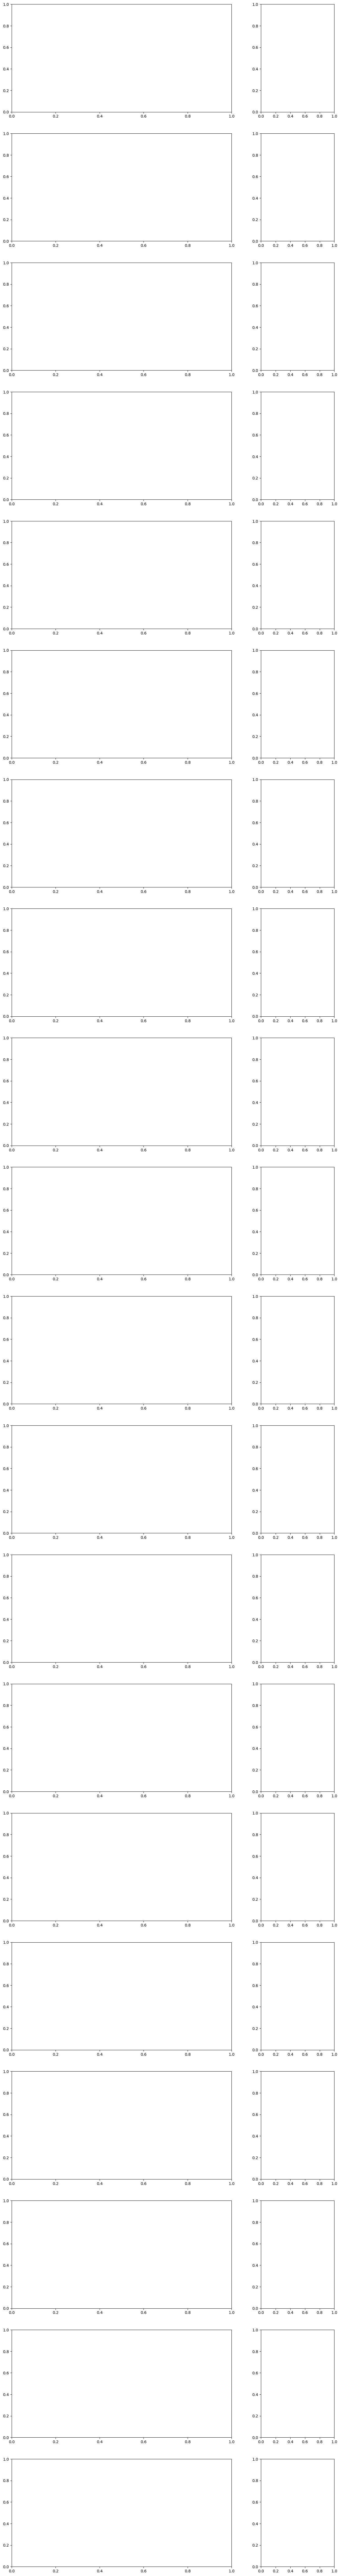

In [25]:
filtered_wavelengths, filtered_fluxes, filtered_errors = filter_wavelength_range(
    wavelengths=all_wavelengths,
    fluxes=all_fluxes_padded,
    errors=all_errors_padded,
    min_wavelength=4000
)

# Detect anomalies with updated output
(anomalous_regions, spectrum_anomalies, anomaly_metadata, 
 abs_residual_threshold, rel_residual_threshold, range_mismatch_factor) = detect_anomalous_regions(
    original_fluxes=all_fluxes_tensor.numpy().squeeze(),
    reconstructed_fluxes=reconstructed_fluxes,
    window_size=50,
    percentile_threshold=95,
    range_mismatch_factor=1.5,
    overall_anomaly_threshold=0.3
)

# Compute reconstruction errors
reconstruction_errors = compute_reconstruction_errors(
    original_fluxes=all_fluxes_tensor.numpy().squeeze(),
    reconstructed_fluxes=reconstructed_fluxes
)

# Plot and save the reconstruction error distribution
plot_reconstruction_error(
    reconstruction_errors=reconstruction_errors,
    wavelengths=wavelengths,  
    save_directory=OUT_DIR
)

# Plot and save anomalous spectra
anomalous_indices, plot_indices, seed = plot_spectra(
    original_fluxes=all_fluxes_tensor.numpy().squeeze(),
    reconstructed_fluxes=reconstructed_fluxes,
    anomalous_regions=anomalous_regions,
    spectrum_anomalies=spectrum_anomalies,
    zpix_cat=zpix_cat,
    wavelengths=wavelengths,  
    save_directory='SpectralCNNAutoencoder_output',
    max_samples= 20,
    only_anomalous=True
)

# Save the sampling information with the thresholds and metadata, using target IDs from zpix_cat
save_sampling_info(
    galaxy_ids=anomalous_indices,        
    plot_galaxy_ids=plot_indices,        
    seed=seed,
    anomaly_metadata=anomaly_metadata, 
    abs_residual_threshold=abs_residual_threshold, 
    rel_residual_threshold=rel_residual_threshold, 
    range_mismatch_factor=range_mismatch_factor, 
    json_directory=JSON_DIR, 
    zpix_cat=zpix_cat
)
# Filter wavelengths, fluxes, and errors to remove wavelengths below 4000
wavelengths, fluxes, errors = filter_wavelength_range(
    wavelengths=all_wavelengths,
    fluxes=all_fluxes_padded,
    errors=all_errors_padded,
    min_wavelength=4000
)

# Update tensors for removing noisy blue wavelengths.
all_fluxes_tensor = torch.tensor(np.array(fluxes), dtype=torch.float32).unsqueeze(1)
all_errors_tensor = torch.tensor(np.array(errors), dtype=torch.float32).unsqueeze(1)


# Detect anomalies with updated fluxes
(anomalous_regions, spectrum_anomalies, anomaly_metadata, 
 abs_residual_threshold, rel_residual_threshold, range_mismatch_factor) = detect_anomalous_regions(
    original_fluxes=all_fluxes_tensor.numpy().squeeze(),
    reconstructed_fluxes=reconstructed_fluxes,
    window_size=50,
    percentile_threshold=95,
    range_mismatch_factor=1.5,
    overall_anomaly_threshold=0.3
)

# Compute reconstruction errors
reconstruction_errors = compute_reconstruction_errors(
    original_fluxes=all_fluxes_tensor.numpy().squeeze(),
    reconstructed_fluxes=reconstructed_fluxes
)

# Plot and save the reconstruction error distribution
plot_reconstruction_error_distribution(
    reconstruction_errors=reconstruction_errors,
    wavelengths=wavelengths,  # Updated wavelengths
    save_directory=OUT_DIR
)

# Plot and save anomalous spectra
anomalous_indices, plot_indices, seed = plot_spectra(
    original_fluxes=all_fluxes_tensor.numpy().squeeze(),
    reconstructed_fluxes=reconstructed_fluxes,
    anomalous_regions=anomalous_regions,
    spectrum_anomalies=spectrum_anomalies,
    zpix_cat=zpix_cat,
    wavelengths=wavelengths,
    save_directory='SpectralCNNAutoencoder_output',
    max_samples=20,
    only_anomalous=True
)

# Save the sampling information with the thresholds and metadata, using target IDs from zpix_cat
save_sampling_info(
    galaxy_ids=anomalous_indices,        
    plot_galaxy_ids=plot_indices,        
    seed=seed,
    anomaly_metadata=anomaly_metadata, 
    abs_residual_threshold=abs_residual_threshold, 
    rel_residual_threshold=rel_residual_threshold, 
    range_mismatch_factor=range_mismatch_factor, 
    json_directory=JSON_DIR, 
    zpix_cat=zpix_cat
)

In [ ]:
# Extract redshift values from the zpix_cat DataFrame
redshifts = zpix_cat['z'].to_numpy()

# Plot histogram of redshifts
plt.figure(figsize=(12, 6))
sns.histplot(redshifts, bins=50, kde=True, color="blue", alpha=0.7)
plt.xlabel("Redshift (z)")
plt.ylabel("Count")
plt.title("Distribution of Redshifts in the Dataset")
plt.grid(True)
plt.show()

# Optional: Print statistics
print(f"Total Galaxies: {len(redshifts)}")
print(f"Redshift Range: {redshifts.min():.2f} - {redshifts.max():.2f}")
print(f"Mean Redshift: {redshifts.mean():.2f}")
print(f"Median Redshift: {np.median(redshifts):.2f}")


# vvvvvvvvvvv DEBUG ZONE vvvvvvvvvvv

In [23]:
wavelengths, fluxes, errors = filter_wavelength_range(
    wavelengths=all_wavelengths,
    fluxes=all_fluxes_padded,
    errors=all_errors_padded,
    min_wavelength=4000
)


# Validate shapes after filtering
print("Filtered Wavelengths Shape:", len(wavelengths))
print("Filtered Fluxes Shape:", fluxes.shape)
print("Reconstructed Fluxes Shape:", reconstructed_fluxes.shape)
# Compare unfiltered and filtered data
print("Original Flux Shape:", all_fluxes_padded.shape)
print("Filtered Flux Shape:", np.array(fluxes).shape)

# Verify that the filtered spectra align with the original length
if all_fluxes_padded.shape[1] != np.array(fluxes).shape[1]:
    print("Filtered flux length does not match original flux length!")



Filtered Wavelengths Shape: 738


AttributeError: 'list' object has no attribute 'shape'

In [ ]:
redshift_min = zpix_cat['z'].min()
redshift_max = zpix_cat['z'].max()
print(f"Redshift range of galaxies: {redshift_min:.3f} - {redshift_max:.3f}")

In [ ]:
# Define redshift ranges
redshift_ranges = {
    'Very Low Redshift (z < 0.1)': (0, 0.1),
    'Low Redshift (0.1 ≤ z < 0.5)': (0.1, 0.5),
    'Intermediate Redshift (0.5 ≤ z < 1.0)': (0.5, 1.0),
    'High Redshift (1.0 ≤ z < 1.5)': (1.0, 1.5),
    'Very High Redshift (1.5 ≤ z ≤ 1.692)': (1.5, 1.692)
}

# Count galaxies in each redshift range without modifying the DataFrame
redshift_category_counts = {
    label: ((zpix_cat['z'] >= range_min) & (zpix_cat['z'] < range_max)).sum()
    for label, (range_min, range_max) in redshift_ranges.items()
}

# Display results
for category, count in redshift_category_counts.items():
    print(f"{category}: {count} galaxies")


In [ ]:
def shift_to_rest_frame(wavelengths, fluxes, errors, redshifts, target_length=None):
    """
    Shifts spectra to the rest frame and pads/truncates them to a standard length.

    Parameters:
    - wavelengths (list of np.ndarray): Observed wavelengths for each spectrum.
    - fluxes (list of np.ndarray): Flux values for each spectrum.
    - errors (list of np.ndarray): Error values for each spectrum.
    - redshifts (np.ndarray): Redshift values for each galaxy.
    - target_length (int, optional): Target length for padding/truncation. If None, use the maximum length.

    Returns:
    - rest_frame_wavelengths (np.ndarray): Padded/truncated rest-frame wavelengths.
    - rest_frame_fluxes (np.ndarray): Padded/truncated fluxes in the rest frame.
    - rest_frame_errors (np.ndarray): Padded/truncated errors in the rest frame.
    """
    num_spectra = len(wavelengths)

    # Validate inputs
    assert len(wavelengths) == len(fluxes) == len(errors) == len(redshifts), "Input lengths must match."

    # Convert to rest-frame wavelengths
    rest_wavelengths = [wavelengths[i] / (1 + redshifts[i]) for i in range(num_spectra)]

    # Determine the target length if not provided
    if target_length is None:
        target_length = max(len(w) for w in rest_wavelengths)

    # Pad or truncate wavelengths, fluxes, and errors
    padded_wavelengths = pad_spectra(rest_wavelengths, target_length)
    padded_fluxes = pad_spectra(fluxes, target_length)
    padded_errors = pad_spectra(errors, target_length)

    print(f"Shifted {num_spectra} spectra to the rest frame with target length {target_length}.")

    return padded_wavelengths, padded_fluxes, padded_errors


# Example Usage
adjusted_wavelengths, adjusted_fluxes, adjusted_errors = shift_to_rest_frame(
    wavelengths=all_wavelengths,
    fluxes=all_fluxes_padded,
    errors=all_errors_padded,
    redshifts=zpix_cat['z'].to_numpy()
)



In [ ]:
# Visualize all spectra with colors representing redshift values
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable, viridis

# Extract redshifts for colormap normalization
redshifts = zpix_cat['z'].to_numpy()

# Normalize redshift values for color mapping
norm = Normalize(vmin=redshifts.min(), vmax=redshifts.max())
cmap = plt.cm.viridis  # Classic astrophysics colormap

# Create the plot
plt.figure(figsize=(14, 8))
for i in range(len(adjusted_wavelengths)):
    color = cmap(norm(redshifts[i]))  # Map redshift to a color
    plt.plot(adjusted_wavelengths[i], adjusted_fluxes[i], color=color, alpha=0.6, linewidth=0.5)

# Add colorbar to represent redshift values
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, orientation="vertical")
cbar.set_label("Redshift (z)", fontsize=12)

# Label the plot
plt.xlabel("Rest-Frame Wavelength (Å)")
plt.ylabel("Flux")
plt.title("All Spectra Adjusted to Rest Frame with Redshift Gradient")
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import viridis
from matplotlib.colors import Normalize

def plot_and_save_representative_spectra(wavelengths, fluxes, redshifts, save_path="representative_spectra.png"):
    """
    Plots representative galaxy spectra across 50 equally spaced redshift bins from 0 to max redshift and saves the plot.

    Parameters:
    - wavelengths (list of np.ndarray): Rest-frame wavelengths for each galaxy.
    - fluxes (list of np.ndarray): Fluxes for each galaxy.
    - redshifts (np.ndarray): Redshift values for each galaxy.
    - save_path (str): File path to save the plot.
    """
    # Create 50 equally spaced bins from 0 to max redshift
    bins = np.linspace(0, redshifts.max(), 15)
    bin_indices = np.digitize(redshifts, bins) - 1  # Map redshifts to bins
    unique_bins = np.unique(bin_indices)
    
    # Create the plot
    plt.figure(figsize=(14, 8))
    cmap = plt.cm.viridis  # Colormap
    norm = Normalize(vmin=redshifts.min(), vmax=redshifts.max())
    
    for bin_idx in unique_bins:
        # Get the first galaxy in this bin
        galaxy_indices = np.where(bin_indices == bin_idx)[0]
        if len(galaxy_indices) > 0:  # Ensure there are galaxies in the bin
            galaxy_idx = galaxy_indices[0]
            
            # Get redshift, wavelength, and flux for this galaxy
            redshift = redshifts[galaxy_idx]
            wavelength = wavelengths[galaxy_idx]
            flux = fluxes[galaxy_idx]
            
            # Ignore negative flux values
            flux = np.where(flux < 0, 0, flux)
            
            # Plot the spectrum
            color = cmap(norm(redshift))  # Map redshift to a color
            plt.plot(wavelength, flux, label=f"z = {redshift:.2f}", color=color, alpha=0.9)

    # Add colorbar for redshift
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, orientation="vertical")
    cbar.set_label("Redshift (z)", fontsize=12)

    # Add legend and labels
    plt.xlabel("Rest-Frame Wavelength (Å)")
    plt.ylabel("Flux")
    plt.title("Representative Galaxies Across Full Redshift Range")
    plt.legend(loc="upper right", fontsize=10, ncol=2)
    plt.grid(alpha=0.3)
    plt.tight_layout()

    # Save the plot
    plt.savefig(save_path, dpi=300)
    print(f"Plot saved to {save_path}")
    plt.show()

# Call the function with example data
plot_and_save_representative_spectra(
    wavelengths=adjusted_wavelengths,
    fluxes=adjusted_fluxes,
    redshifts=zpix_cat['z'].to_numpy(),
    save_path="representative_spectra.png"
)


In [ ]:
# Ensure adjusted fluxes have no zeros or negative values
adjusted_fluxes[adjusted_fluxes <= 0] = np.finfo(float).eps  # Replace non-positive values
adjusted_fluxes = (adjusted_fluxes - adjusted_fluxes.min()) / (adjusted_fluxes.max() - adjusted_fluxes.min())

# Convert to tensors
adjusted_fluxes_tensor = torch.tensor(adjusted_fluxes, dtype=torch.float32).unsqueeze(1)
adjusted_errors_tensor = torch.tensor(adjusted_errors, dtype=torch.float32).unsqueeze(1)

# Generate mask tensor
mask = (adjusted_fluxes > 0).astype(float)
mask_tensor = torch.tensor(mask, dtype=torch.float32).unsqueeze(1)

# Train autoencoder
autoencoder = CNNAutoencoderWithSkip()
train_autoencoder(autoencoder, adjusted_fluxes_tensor, mask_tensor, adjusted_errors_tensor)

# Evaluate and reconstruct
autoencoder.eval()
reconstructed_fluxes = autoencoder(adjusted_fluxes_tensor).detach().numpy().squeeze()

# Detect anomalies
(anomalous_regions, spectrum_anomalies, anomaly_metadata, 
 abs_residual_threshold, rel_residual_threshold, range_mismatch_factor) = detect_anomalous_regions(
    original_fluxes=adjusted_fluxes_tensor.numpy().squeeze(),
    reconstructed_fluxes=reconstructed_fluxes,
    window_size=50,
    percentile_threshold=95,
    range_mismatch_factor=1.5,
    overall_anomaly_threshold=0.3
)

# Save reconstruction error plot
plot_reconstruction_error_distribution(
    reconstruction_errors=reconstruction_errors,
    wavelengths=adjusted_wavelengths[0],
    save_directory=OUT_DIR
)


In [ ]:
def validate_redshift_spectrum_correspondence(wavelengths, fluxes, errors, redshifts):
    """
    Validates that each redshift corresponds to the correct spectrum.
    
    Parameters:
    - wavelengths (list of np.ndarray): Original observed wavelengths.
    - fluxes (list of np.ndarray): Observed flux values.
    - errors (list of np.ndarray): Observed error values.
    - redshifts (np.ndarray): Redshift values for each spectrum.
    """
    # Check lengths of all inputs
    print("Checking input consistency...")
    assert len(wavelengths) == len(fluxes) == len(errors) == len(redshifts), \
        "Mismatch in lengths of input arrays!"
    print("Lengths are consistent.")

    # Validate each spectrum corresponds to the correct redshift
    print("\nValidating redshift correspondence for first 5 spectra...")
    for i in range(min(5, len(wavelengths))):  # Check the first 5 spectra
        print(f"\nSpectrum {i + 1}:")
        print(f"Original wavelengths: {wavelengths[i][:5]}")  # First 5 wavelengths
        print(f"Redshift: {redshifts[i]}")
        rest_wavelengths = wavelengths[i] / (1 + redshifts[i])
        print(f"Expected rest-frame wavelengths: {rest_wavelengths[:5]}")
        print(f"Observed rest-frame wavelengths: {wavelengths[i][:5] / (1 + redshifts[i])}")

        # Verify the flux alignment
        assert len(wavelengths[i]) == len(fluxes[i]) == len(errors[i]), \
            f"Mismatch in wavelengths, fluxes, and errors for spectrum {i + 1}!"
        print(f"Spectrum {i + 1} lengths are aligned.")

    print("\nRedshift correspondence validation complete.")
# Example usage:
validate_redshift_spectrum_correspondence(
    wavelengths=all_wavelengths,
    fluxes=all_fluxes_padded,
    errors=all_errors_padded,
    redshifts=zpix_cat['z'].to_numpy()
)



In [ ]:
def plot_spectra(
    original_fluxes, reconstructed_fluxes, anomalous_regions, spectrum_anomalies,
    zpix_cat, wavelengths=None, save_directory='SpectralCNNAutoencoder_output', max_samples=20, 
    seed=None, only_anomalous=True
):
    """
    Plots spectra with optional anomaly highlighting.
    """
    # Validate dimensions
    assert original_fluxes.shape == reconstructed_fluxes.shape, "Original and reconstructed fluxes must have the same shape"
    assert len(original_fluxes) == len(anomalous_regions) == len(spectrum_anomalies), \
        "Mismatch in the number of spectra across inputs"
    
    if wavelengths is not None:
        assert len(wavelengths) == original_fluxes.shape[1], \
            "Wavelength length must match the number of flux points per spectrum"
        x_axis = wavelengths
    else:
        x_axis = np.arange(original_fluxes.shape[1])

    # Select spectra to plot
    filtered_indices = list(range(len(original_fluxes))) if not only_anomalous else \
        [i for i, anomaly in enumerate(spectrum_anomalies) if anomaly]
    if seed is not None:
        random.seed(seed)
    plot_indices = random.sample(filtered_indices, min(max_samples, len(filtered_indices)))

    # Plotting
    fig, axes = plt.subplots(len(plot_indices), 1, figsize=(15, 6 * len(plot_indices)))
    if len(plot_indices) == 1:
        axes = [axes]

    for idx, i in enumerate(plot_indices):
        ax = axes[idx]
        ax.plot(x_axis, original_fluxes[i], label="Original", color='blue', linewidth=0.5)
        ax.plot(x_axis, reconstructed_fluxes[i], label="Reconstructed", color='red', alpha=0.7, linewidth=0.5)
        
        # Highlight anomalous regions
        for start, is_anomalous in enumerate(anomalous_regions[i]):
            if is_anomalous:
                ax.axvspan(x_axis[start], x_axis[start + 1], color='yellow', alpha=0.3)

        ax.set_title(f"Spectrum ID: {zpix_cat.iloc[i]['targetid']}")
        ax.set_xlabel("Wavelength (Å)")
        ax.set_ylabel("Flux")
        ax.legend()

    plt.tight_layout()
    os.makedirs(save_directory, exist_ok=True)
    save_path = os.path.join(save_directory, "spectra_plot.png")
    plt.savefig(save_path)
    plt.close()
    print(f"Plot saved to {save_path}")

    return filtered_indices, plot_indices, seed


In [ ]:
anomalous_indices, plot_indices, seed = plot_spectra(
    original_fluxes=all_fluxes_tensor.numpy().squeeze(),
    reconstructed_fluxes=reconstructed_fluxes,
    anomalous_regions=anomalous_regions,
    spectrum_anomalies=spectrum_anomalies,
    zpix_cat=zpix_cat,
    wavelengths=wavelengths,
    save_directory='SpectralCNNAutoencoder_output',
    max_samples=20,
    only_anomalous=True
)
